Présentation: 
1. étape d'encodage: 
entraînement d'un encodeur en utilisant le dataset du train **par type de machine**: un modele d'encodeur par type de machine est entraîné: l'encodeur a pour objectif de maximiser l'espace entre les signaux de machines différentes, et minimiser l'espace entre les signaux d'une même machine 
1. test d'algo de détection d'outlier et novelty, avec une étape prélable de réduction de dimensions. Les données d'entrée sont les signaux encodés grâce au modèle entraîné à l'étape précédente

# Ier lancement: téléchargement des données

Les données sont téléchargées de Kaggle pour être utilisées sur sur la machine Collab (environ 3mn à la première exécution)

**conseils pour faire fonctionner le notebook sur le dataset complet: GPU + RAM élevée (25 Go en collab pro)**

In [6]:
import os
import pathlib

from google.colab import drive
drive.mount("/content/gdrive")

! pip install -q kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle" # dossier drive où a été stocké préalablement le fichier json kaggle de credentials

data_dir = pathlib.Path('dataset')
! kaggle datasets download -d daisukelab/dc2020task2
! unzip dc2020task2.zip -d dataset # unzip dans le dossier 'dataset' de la VM google

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
dc2020task2.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  dc2020task2.zip
replace dataset/ToyCar/test/anomaly_id_01_00000000.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# imports

importe les librairies, dont le fichier de fonctions personnalisées stocké sur le drive toolbox.py as tb, contenant les méthodes et variables utiles au projet


In [7]:
%load_ext autoreload
%autoreload 2 #force à recherger les imports, notamment la toolbox parès modification

from tqdm.notebook import tqdm, trange 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import random
import time

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras import regularizers

from sklearn.neighbors import KNeighborsClassifier

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
%matplotlib inline


#import de notre bibliothèque perso
!cp -f /content/gdrive/MyDrive/Datascientest/PROJET/PyGoodVibes/Notebooks/toolbox2.py toolbox2.py

import toolbox2 as tb




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Entraînement encodeur
entrainement par type de machine: 
* level 1: type de machine
* level 2: par id de machine

## chargement des noms des fichiers du set: entraînement et test
nécessite environ 3mn sur tout le dataset pour déterminer les identifiants uniques de machine

_todo_: optimiser le chargement des label machine par tf?

In [8]:
data_dir = pathlib.Path('dataset')
available_machines = tf.io.gfile.listdir(str(data_dir))
print('machines disponibles:')
for m in available_machines:
  print('- ',m)

machines disponibles:
-  pump
-  slider
-  fan
-  valve
-  ToyCar
-  ToyConveyor


In [9]:
#choix des machines à étudier
tb.spectro_size = (512,256)
selected_machines= [
               'ToyCar',
               'ToyConveyor',
               'fan',
               'pump',
               'slider',
               'valve'
               ]



files_train,files_test,tb.machine_list,tb.machine_id_list,machine_train_dict,machine_test_dict = tb.select_inputfile(data_dir, selected_machines)


dataset sélectionnés:
-  ToyCar
-  ToyConveyor
-  fan
-  pump
-  slider
-  valve

recherche des labels et id des machines sélectionnées, parmi tous les fichiers d'entraînement:


- ToyCar_02
- ToyCar_03
- ToyCar_01
- ToyCar_04
- ToyConveyor_02
- ToyConveyor_03
- ToyConveyor_01
- fan_02
- fan_00
- fan_04
- fan_06
- pump_02
- pump_00
- pump_04
- pump_06
- slider_02
- slider_00
- slider_04
- slider_06
- valve_02
- valve_00
- valve_04
- valve_06


recherche des labels et id des machines sélectionnées, parmi tous les fichiers de tests:


- ToyCar_01
- ToyCar_02
- ToyCar_03
- ToyCar_04
- ToyConveyor_02
- ToyConveyor_01
- ToyConveyor_03
- fan_02
- fan_04
- fan_00
- fan_06
- pump_02
- pump_04
- pump_00
- pump_06
- slider_02
- slider_04
- slider_00
- slider_06
- valve_02
- valve_04
- valve_00
- valve_06



## test de fonctions de la toolbox
optionnel pour vérification du fonctionnement de la toolbox
vérifie que les labels sont bien déterminés 

In [ ]:
# for i in range(0,len(files_train),100):
#   waveform, label, sr = get_waveform_and_machine_id(files[i])
#   spec,label_id = get_spectrogram_and_label_id(waveform,label,sr)
#   print("file: {}, label:{}, label_id: {}".format(files[i],label.numpy().decode('utf-8'),label_id))

for file in random.sample(files_train,10):
  waveform, label, sr = tb.get_waveform_and_machine_id(file)
  spec,label_id = tb.get_spectrogram_and_machine_id(waveform,label,sr)
  print("file: {}, label:{},".format(file,label_id))

for file in random.sample(files_test,10):
  waveform, label, sr = tb.get_waveform_and_machine_id(file)
  spec,label_id = tb.get_spectrogram_and_machine_id(waveform,label,sr)
  print("file: {}, label:{},".format(file,label_id))

for file in random.sample(files_test,10):
  waveform, label, sr,anomaly = tb.get_waveform_and_machine_id_and_anomaly(file)
  spec,label_id,anomaly = tb.get_spectrogram_and_machine_id_and_anomaly(waveform,label,sr,anomaly)
  print("file: {}, label:{}, anomalie:{}".format(file,label_id,anomaly))




file: dataset/pump/train/normal_id_06_00000909.wav, label:2,
file: dataset/pump/train/normal_id_06_00000148.wav, label:2,
file: dataset/pump/train/normal_id_04_00000472.wav, label:3,
file: dataset/pump/train/normal_id_00_00000619.wav, label:1,
file: dataset/pump/train/normal_id_06_00000357.wav, label:2,
file: dataset/pump/train/normal_id_02_00000027.wav, label:0,
file: dataset/pump/train/normal_id_04_00000257.wav, label:3,
file: dataset/pump/train/normal_id_02_00000521.wav, label:0,
file: dataset/pump/train/normal_id_00_00000810.wav, label:1,
file: dataset/pump/train/normal_id_04_00000189.wav, label:3,
file: dataset/pump/test/anomaly_id_02_00000082.wav, label:0,
file: dataset/pump/test/anomaly_id_00_00000017.wav, label:1,
file: dataset/pump/test/normal_id_04_00000041.wav, label:3,
file: dataset/pump/test/normal_id_04_00000071.wav, label:3,
file: dataset/pump/test/normal_id_00_00000003.wav, label:1,
file: dataset/pump/test/anomaly_id_00_00000091.wav, label:1,
file: dataset/pump/test/nor

## Construction encodeur

### Construction dataset
1. création de dataset et mapping pour le calcul des spectrogrammes par machine
1. génération d'un vecteur X[machine_id][spectrogramme] contenant tous les spectrogrammes classés par machine et y[machine][label] contenant leur label
Ces vecteurs X et y seront utilisés par le générateur de data (voir la toolbox) 

In [ ]:
mach = selected_machines
tb.spectro_size=(512,256)
spectro_train_dict = tb.prepare_data_train(mach, machine_train_dict,verbose=1 )
# à documenter

ToyCar
  -machine ToyCar_02      : 1000 spectros générés
  -machine ToyCar_03      : 1000 spectros générés
  -machine ToyCar_01      : 1000 spectros générés
  -machine ToyCar_04      : 1000 spectros générés
ToyConveyor
  -machine ToyConveyor_02 : 1000 spectros générés
  -machine ToyConveyor_03 : 1000 spectros générés
  -machine ToyConveyor_01 : 1000 spectros générés
fan
  -machine fan_02         :  916 spectros générés
  -machine fan_00         :  911 spectros générés
  -machine fan_04         :  933 spectros générés
  -machine fan_06         :  915 spectros générés
valve
  -machine valve_02       :  608 spectros générés
  -machine valve_00       :  891 spectros générés
  -machine valve_04       :  900 spectros générés
  -machine valve_06       :  892 spectros générés
pump
  -machine pump_02        :  905 spectros générés
  -machine pump_00        :  906 spectros générés
  -machine pump_04        :  602 spectros générés
  -machine pump_06        :  936 spectros générés
slider
  -machin

### visualisation de 3 spectros calculés, par machine
vérification du bon calcul des spectros

23


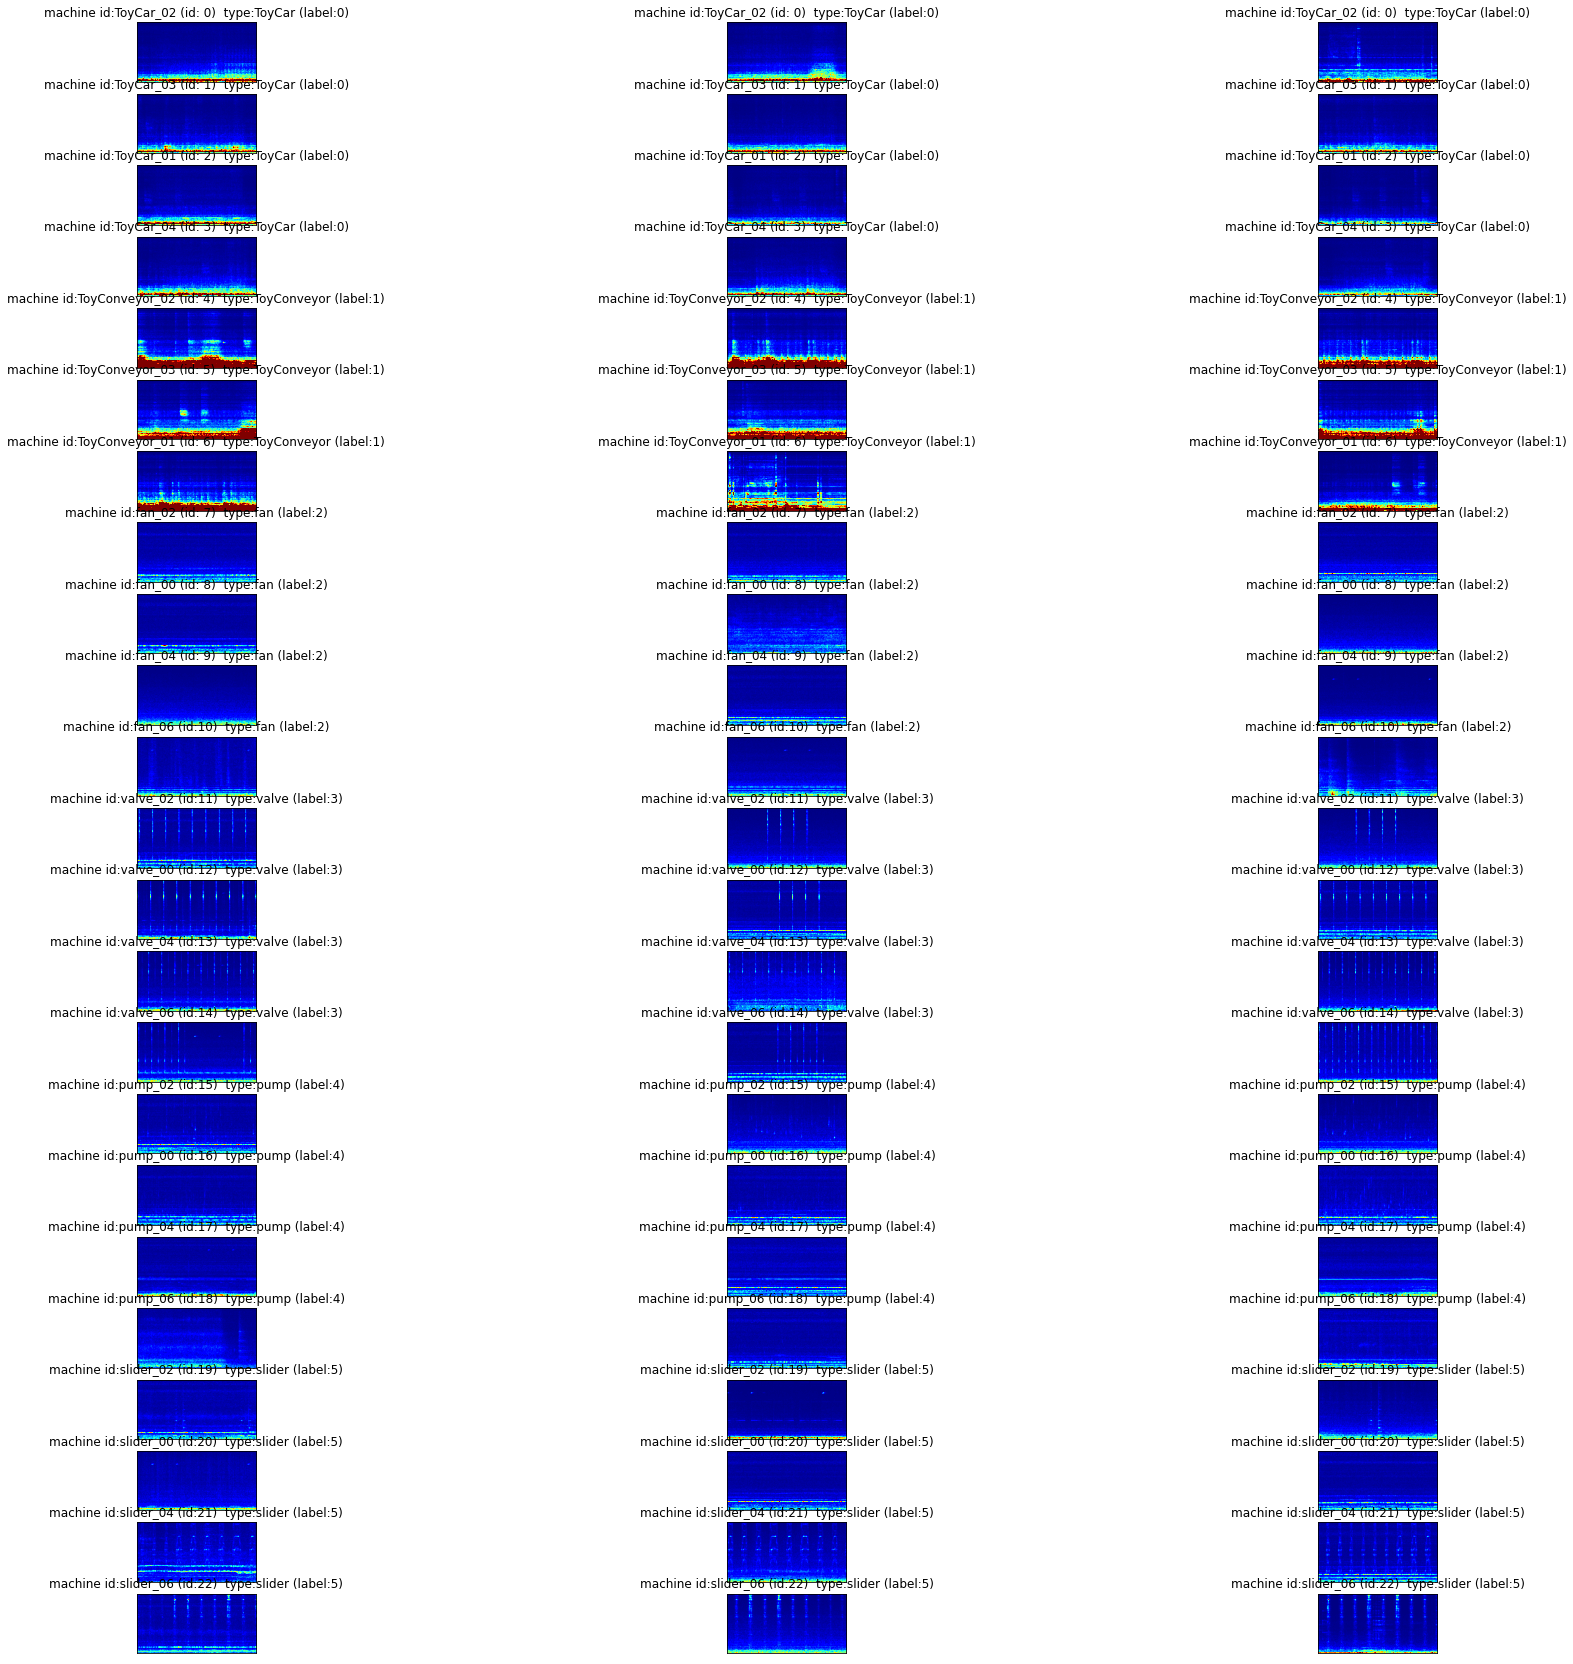

In [ ]:
nb_machines = np.array([len(spectro_train_dict[m]) for m in spectro_train_dict]).sum()
print(nb_machines)
fig = plt.figure(figsize=(30,30))
pos=1
for m in mach:
  for id in spectro_train_dict[m]:
    for j in range(3):
        ax = fig.add_subplot(nb_machines,3,pos)
        im = spectro_train_dict[m][id]['spectro'][j]
        plt.imshow(np.squeeze(im).T,cmap = 'jet',vmin=0,vmax=1, origin='lower')# pour afficher chaque image avec la même dynamique
        plt.title("machine id:{:s} (id:{:2d})  type:{:s} (label:{:d})".format(id,spectro_train_dict[m][id]['machine_id'][j],m,spectro_train_dict[m][id]['label'][j]))
        plt.xticks([])
        plt.yticks([])
        pos+=1

### Modélisation:

 1 encodeur entraîné par type de machine

### vérification du générateur

In [ ]:
# batch_size = tb.batch_size
# def generator_by_level(spec_dict,level, batch_size=batch_size):
#     """
#     dans le cadre du dataset https://www.kaggle.com/daisukelab/dc2020task2
#     Retourne un batch X_batch de (batch_size*3) lignes et les labels correspondant y_batch.
#     Chaque ligne est respectivement un chemin vers un fichier audio et un label de type de machine ou identifiant machine

#     2 lignes/3 sont les fichiers d'une première machine, et 1 ligne/3 est un fichier d'une  2eme machine au label différent

#     :param spec_dict: dict: contient les infos de type/machine/spectro-anomaly-label.
#     :param level: level=1: generateur sur type de machine. Generateur = 2: generateur sur machine indivuelle
#     :param batch_size: nombre de trio de fichiers à constituer
#     :return: (string liste de fichiers, liste des labels des fichiers)
#     """
#     this_spect = []
#     this_machid = []
  
#     n_files=0
#     mach_file=0
#     base_level=0
#     n_file_level = 0   

#     ID_range = 0 
#     machines = []
#     machines_range = [] 
    
#     for mach_type in spec_dict:
        
#         if level==1:
#           machines.append(mach_type)
#           ID_range+=1
#           base_level = n_files
#           n_file_level = 0

#         for mach in spec_dict[mach_type]:
         
#           n_file_mach = len(spec_dict[mach_type][mach]['machine_id'])
#           n_files += n_file_mach
          
#           this_spect.extend(spec_dict[mach_type][mach]['spectro'])
#           this_machid.extend(spec_dict[mach_type][mach]['machine_id'])

#           if level==1:
#             n_file_level += n_file_mach

#           else:
#             machines.append(mach)
#             ID_range +=1
#             n_file_level = n_file_mach
#             machines_range.append(range(base_level,base_level + n_file_level))
#             base_level = n_files          
        
#         if level==1:
#           machines_range.append(range(base_level,base_level + n_file_level))

#     ID_range = range(0,ID_range) 
#     while (True):
#         for i in range(0, n_files, batch_size):
#             X_batch = []
#             y_batch = []
#             for j in range(0, batch_size):
#                 ID1, ID2 = random.sample(ID_range, 2)
#                 ID1_range = machines_range[ID1]
#                 ID2_range = machines_range[ID2]
#                 id1_spec_1, id1_spec_2 = random.sample(ID1_range, 2)
#                 id2_spec_1 = random.sample(ID2_range,1)[0]
                
#                 X_batch.extend([this_spect[id1_spec_1],
#                                 this_spect[id1_spec_2],
#                                 this_spect[id2_spec_1]])

#                 y_batch.extend([this_machid[id1_spec_1],
#                                 this_machid[id1_spec_2],
#                                 this_machid[id2_spec_1]])
#             X_batch = np.array(X_batch)
#             y_batch = np.array(y_batch)

#             yield X_batch, y_batch

In [ ]:
#test de génération des batchs
gen = tb.generator_by_level(spectro_train_dict, level=2,batch_size=12)
X_t, y_t = next(gen)

nb =12
plt.figure(figsize=(30,5*nb))
for i in range(nb):
    for j in range(3):
        plt.subplot(nb,3,i*3 + j +1)
        im = X_t[i*3+j]
        plt.imshow(np.squeeze(im).T,cmap = 'jet',vmin=0, vmax=1, origin='lower') #
        plt.title("machine label: {} {}".format(y_t[i*3+j],tb.machine_id_list[y_t[i*3+j]]))
        plt.xticks([])
        plt.yticks([])

Output hidden; open in https://colab.research.google.com to view.

### entraînement

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop


def train_encoder(data_to_train, level=2, batch_size=12,epochs = 20,model= None, learning_rate=5e-4, plot=True,verbose=1):
    
    n_epochs = epochs
    lr = learning_rate

    if model==None:
        model = tb.createModel()
        model.compile(loss=tb.loss, optimizer=Adam(lr))#5e-3

    if verbose:
      print("jeu de données d'apprentissage:",list(data_to_train.keys()))
      if level==1:
        print("==============================================================\n"
              "  apprentissage pour encodage différenciant le type de machine\n"
              "===============================================================")
      else:
        print("==============================================================\n"
              "  apprentissage pour encodage différenciant chaque machine\n"
              "===============================================================")
        for mach_type in data_to_train:
          print(list(data_to_train[mach_type].keys()))
        print("===============================================================\n")
      
    if verbose >1:
        model.summary()

    n=0
    for mach in data_to_train:
        for mach_id in data_to_train[mach].keys():
            n+=len(data_to_train[mach][mach_id]['spectro'])

    gen = tb.generator_by_level(data_to_train, level, batch_size)
    
    t0 = time.time()
    fit_verbose = verbose-1
    history = model.fit(gen, epochs=n_epochs,steps_per_epoch=int(n/10/len(data_to_train[mach])),verbose=fit_verbose)
    t1 = time.time()
    if verbose:
        print("machine {}: apprentissage effectué en {:.3f}mn".format(mach,(t1-t0)/60))
        print("____________________________________________________________________")

    if plot:
        plt.figure()
        plt.plot(history.history['loss'])
        plt.title("apprentissage machine {} avec learning rate= {:.2E}".format(mach,lr));

    return model

jeu de données d'apprentissage: ['ToyCar', 'ToyConveyor', 'fan', 'pump', 'slider', 'valve']
  apprentissage pour encodage différenciant le type de machine
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 256, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 64, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 64, 64)       73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (Non

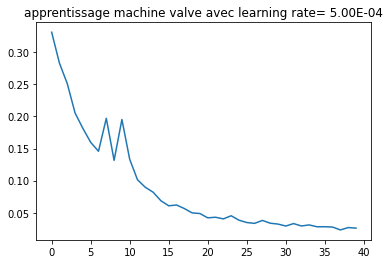

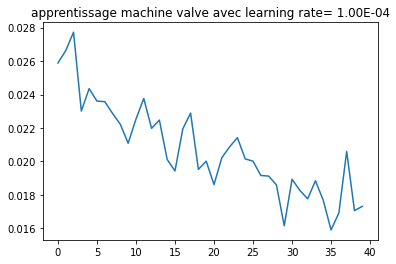

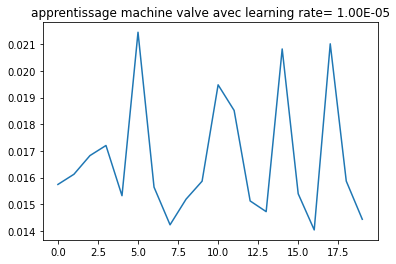

In [ ]:
encoder = train_encoder(spectro_train_dict, level=1,batch_size=12, epochs = 40,learning_rate=5e-4,plot=True,verbose=2)
encoder = train_encoder(spectro_train_dict, model=encoder, level=1,batch_size=12, epochs = 40,learning_rate=1e-5,plot=True,verbose=2)
#encoder = train_encoder(spectro_train_dict, model=encoder, level=1,batch_size=12, epochs = 20,learning_rate=1e-5,plot=True,verbose=2)


### enregistrement: 
ne plus exécuter: les fichiers sont figés pour assurer le fonctionnement

In [ ]:
# mach = 'all'
# nom_fichier = input("personnaliser le nom du fichier?")
# root_path = "/content/gdrive/MyDrive/Datascientest/PROJET/PyGoodVibes/Models/"
# nom_final = root_path+mach+"_weight_encoder_model_"+nom_fichier+".h5"

# encoder.save_weights(nom_final, save_format='h5')
# print("encodeur pour {} enregistré sous le chemin {} ".format(mach,nom_final))


personnaliser le nom du fichier?type
encodeur pour all enregistré sous le chemin /content/gdrive/MyDrive/Datascientest/PROJET/PyGoodVibes/Models/all_weight_encoder_model_type.h5 


# chargement des fichiers à traiter

In [ ]:
print("chargement des fichiers sons:\n")
if mach =='all':
  test = input("souhaitez vous tester toutes les machines ? (o/n)")
  if test == 'n':
    mach = input("machine à tester:")
    selected_machines = [mach]
  else:
    selected_machines = ['ToyCar','ToyConveyor','fan','valve','pump','slider']
else:
  selected_machines = [mach]
files_train,files_test,tb.machine_list,tb.machine_id_list,machine_train_dict,machine_test_dict = tb.select_inputfile(data_dir, selected_machines)


chargement des fichiers sons:

souhaitez vous tester toutes les machines ? (o/n)o

dataset sélectionnés:
-  ToyCar
-  ToyConveyor
-  fan
-  valve
-  pump
-  slider

recherche des labels et id des machines sélectionnées, parmi tous les fichiers d'entraînement:


- ToyCar_02
- ToyCar_03
- ToyCar_01
- ToyCar_04
- ToyConveyor_02
- ToyConveyor_03
- ToyConveyor_01
- fan_02
- fan_00
- fan_04
- fan_06
- valve_02
- valve_00
- valve_04
- valve_06
- pump_02
- pump_00
- pump_04
- pump_06
- slider_02
- slider_00
- slider_04
- slider_06


recherche des labels et id des machines sélectionnées, parmi tous les fichiers de tests:


- ToyCar_01
- ToyCar_02
- ToyCar_03
- ToyCar_04
- ToyConveyor_02
- ToyConveyor_01
- ToyConveyor_03
- fan_02
- fan_04
- fan_00
- fan_06
- valve_02
- valve_04
- valve_00
- valve_06
- pump_02
- pump_04
- pump_00
- pump_06
- slider_02
- slider_04
- slider_00
- slider_06



# Création de spectros

**Attention:** si tout le dataset a été chargé, il est nécessaire de disposer de 25Go de RAM pour permettre le calcul des spectros des signaux audio

Nécessite environ 6 à 7 mn pour la totalité du dataset

In [14]:
spec_train,label_train,machine_train,anomaly_train = createData(files_train, verbose=1)
spec_test,label_test,machine_test,anomaly_test = createData(files_test, verbose=1)


création du pipeline de preprocessing des données ...
création des données...
génération des spectrogrammes de 20119 fichiers en 230.39s (temps moyen de 11.451ms par fichier)
création du pipeline de preprocessing des données ...
création des données...
génération des spectrogrammes de 10868 fichiers en 126.02s (temps moyen de 11.595ms par fichier)


# chargement des modèles encodeur

In [228]:
data_dir =  pathlib.Path('dataset')

mach = input("modèle d'encodage à tester?\n"
"-all\n"
"-ToyConveyor\n"
"-ToyCar\n"
"-slider\n"
"-fan\n"
"-pump\n"
"-valve\n")

nom_fichier = input("type encodage ?\n"
"-type: par type de machine \n"
"-machine: par idientifiant de machine individuelle\n")


root_dir = "/content/gdrive/MyDrive/Datascientest/PROJET/PyGoodVibes/Models/"
nom_final = root_dir+mach+"_weight_encoder_model_"+nom_fichier+".h5"

encoder = tb.loadModel(nom_final)
print("modèle d'encodage pour {} chargé ({}".format(mach,nom_final))

modèle d'encodage à tester?
-all
-ToyConveyor
-ToyCar
-slider
-fan
-pump
-valve
all
type encodage ?
-type: par type de machine 
-machine: par idientifiant de machine individuelle
machine
modèle d'encodage pour all chargé (/content/gdrive/MyDrive/Datascientest/PROJET/PyGoodVibes/Models/all_weight_encoder_model_machine.h5


# encodage des spectros


In [229]:
#encodage selon le modèle chargé
X_train = encoder.predict(spec_train)
X_test = encoder.predict(spec_test)

## Analyse en Composantes Principales 


In [230]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

info = pca.explained_variance_ratio_.cumsum()
seuil_pca = 0.9999
component = list(info>seuil_pca).index(True)+1

df = pd.DataFrame({
                  'x':X_pca_train[:,0],
                   'y':X_pca_train[:,1],
                   'z':X_pca_train[:,2],
                   'label':label_train,
                   'machine':machine_train,
                   'anomaly':anomaly_train
                   })
df.machine = df.machine.replace(to_replace=range(len(tb.machine_id_list)),value=tb.machine_id_list)
df.label = df.label.replace(to_replace=range(len(tb.machine_list)),value=tb.machine_list)
df.anomaly = df.machine.replace(to_replace=range(2),value=['normal', 'anormal'])
import plotly.express as px
import plotly.graph_objects as go 

fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='machine', opacity = 0.4, width=1200, height=1000, title="3 composantes principales, après encodage par type de machine")
fig.update_layout(
    title={
        'x':0.5,
        'xanchor': 'center',
        'font':{'size':22}})
fig.update_layout(annotations=[
       go.layout.Annotation(
            showarrow=False,
            text="{:2d} composantes sélectionnées pour {:.2%} de l'info".format(component,seuil_pca),
            xanchor='center',
            x=0.5,
            yanchor='auto',
            y=1,
            font=dict(
                size=18,
            )
        )])

fig.show()

fig2 = px.scatter_3d(df, x='x', y='y', z='z',
              color='label', opacity = 0.4, width=1200, height=1000, title="3 composantes principales, après encodage par type de machine")
fig2.update_layout(
    title={
        'x':0.5,
        'xanchor': 'center',
        'font':{'size':22}})
fig2.update_layout(annotations=[
       go.layout.Annotation(
            showarrow=False,
            text="{:2d} composantes sélectionnées pour {:.2%} de l'info".format(component,seuil_pca),
            xanchor='center',
            x=0.5,
            yanchor='auto',
            y=1,
            font=dict(
                size=18,
            )
        )])

fig2.show()

Output hidden; open in https://colab.research.google.com to view.

## visualisation des anomalies sur le jeu de test

In [231]:
df_test = pd.DataFrame({
                  'x':X_pca_test[:,0],
                   'y':X_pca_test[:,1],
                   'z':X_pca_test[:,2],
                   'machine':machine_test,
                   'label':label_test,
                   'anomaly':anomaly_test
                   })

df_test.machine = df_test.machine.replace(to_replace=range(len(tb.machine_id_list)),value=tb.machine_id_list)
df_test.anomaly = df_test.anomaly.replace(to_replace=[0,1],value=['normal','anormal'])
df.label = df.label.replace(to_replace=range(len(tb.machine_list)),value=tb.machine_list)

fig = px.scatter_3d(df_test, x='x', y='y', z='z',
              color='anomaly', opacity = 0.4, width=1200, height=1000, title="3 composantes principales, après encodage par type de machine")
fig.update_layout(
    title={
        'x':0.5,
        'xanchor': 'center',
        'font':{'size':22}})
fig.update_layout(annotations=[
       go.layout.Annotation(
            showarrow=False,
            text="{:2d} composantes sélectionnées pour {:.2%} de l'info".format(component,seuil_pca),
            xanchor='center',
            x=0.5,
            yanchor='auto',
            y=1,
            font=dict(
                size=18,
            )
        )])

fig.show()



## visualisation des anomalies par machine

In [232]:
sns.set_theme()

fig2 = plt.figure(figsize=(30,7*len(tb.machine_id_list)))
cols = 2
rows = int(len(tb.machine_id_list))/2+1
for i,m in enumerate(tb.machine_id_list):
  idx = machine_test==i
  ax=fig2.add_subplot(rows,cols,i+1,projection='3d')
  scatter1 = ax.scatter(X_pca_test[idx==True,0], X_pca_test[idx==True,1], X_pca_test[idx==True,2], c=anomaly_test[idx==True],edgecolor='gray',alpha=0.4)
  legend1 =  ax.legend(*scatter1.legend_elements(),
                      loc="lower right", title="anomalie")
  ax.set_title("analyse des données de test de la machine %s"%m);


#apprement queques pb avec plotly pour afficher tous les subplots. 

# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# df_test = pd.DataFrame({
#                   'x':X_pca_test[:,0],
#                    'y':X_pca_test[:,1],
#                    'z':X_pca_test[:,2],
#                    'machine':y_test,
#                    'anomaly':anomaly_test
#                    })
# df_test.machine = df_test.machine.replace(to_replace=range(len(tb.machine_id_list)),value=tb.machine_id_list)
# df_test.anomaly = df_test.anomaly.replace(to_replace=[0,1],value=['normal','anormal'])
# # cols = 2
# # rows = int(len(tb.machine_id_list)/cols)+1
# # typegraphe = [[{'type':'scene'} for c in range(cols)] for r in range(rows)]
# # fig = make_subplots(rows=rows, cols=cols, specs=typegraphe,subplot_titles=tb.machine_id_list)

# # for i, mach in enumerate(tb.machine_id_list):
# #   fig.add_trace(go.Scatter3d(x=df_test[df_test.machine==mach].x, y=df_test[df_test.machine==mach].y,z=df_test[df_test.machine==mach].z, mode='markers',opacity=0.7,
# #                        marker = dict(
# #                                      color = df_test[df_test.machine==mach].anomaly,
# #                                      size = 8
# #                                      #line = dict(width=2)
# #                                    )),row=int(i/2)+1, col=i%2+1)

# # fig.update_layout(height=500*rows, width=1600, title_text="Affichage des anomalies par machine", showlegend=False)
# # fig.show()

# fig_test=[]
# for i, mach in enumerate(tb.machine_id_list):
#   df_fil = df_test[df_test.machine==mach]
#   fig2 = px.scatter_3d(df_fil, x='x', y='y', z='z',
#               color='anomaly', opacity = 0.4, width=800, height=600,size_max=8, title="visualisation des anomalies {}".format(mach))
#   fig2.update_layout(
#       title={
#           'x':0.5,
#           'xanchor': 'center',
#           'font':{'size':22}})


#   fig2.show()
#   fig_test.append(fig2)



Output hidden; open in https://colab.research.google.com to view.

#classif par knn

## classif par type de machine après encodage

score knn: 0.9910536779324056
              precision    recall  f1-score   support

      ToyCar      1.000     1.000     1.000       782
 ToyConveyor      1.000     1.000     1.000       621
         fan      0.977     0.988     0.982       727
        pump      0.991     0.993     0.992       670
      slider      0.977     0.962     0.969       574
       valve      1.000     1.000     1.000       650

    accuracy                          0.991      4024
   macro avg      0.991     0.990     0.991      4024
weighted avg      0.991     0.991     0.991      4024



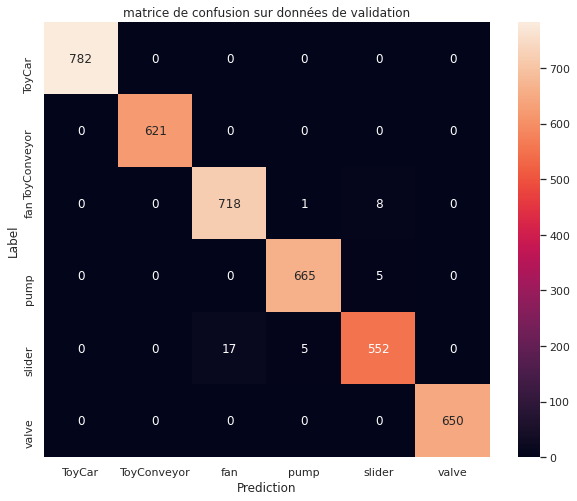

In [233]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pca = PCA(n_components=3)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

X_train_1, X_val, y_train_1, y_val = train_test_split(X_pca_train, label_train.numpy(), train_size=0.8,random_state=1234) #,


knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

knn.fit(X_train_1, y_train_1)
print("score knn:",knn.score(X_val, y_val))

y_pred = knn.predict(X_val)

print(classification_report(y_val,y_pred,target_names=tb.machine_list, digits=3))

confusion_mtx = tf.math.confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
#machine_id = [machine.numpy().decode('utf-8') for machine in machineID]
#sns.heatmap(confusion_mtx, xticklabels=machine_id, yticklabels=machine_id, 
sns.heatmap(confusion_mtx, xticklabels=tb.machine_list, yticklabels=tb.machine_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('matrice de confusion sur données de validation')
plt.show()



##classification par type de machine sur données normale et anormales 

score knn: 0.8985093853514906
              precision    recall  f1-score   support

      ToyCar      1.000     1.000     1.000      2459
 ToyConveyor      1.000     1.000     1.000      3509
         fan      0.922     0.792     0.852      1875
        pump      0.561     0.746     0.640       856
      slider      0.649     0.681     0.664      1290
       valve      1.000     0.904     0.950       879

    accuracy                          0.899     10868
   macro avg      0.855     0.854     0.851     10868
weighted avg      0.910     0.899     0.902     10868



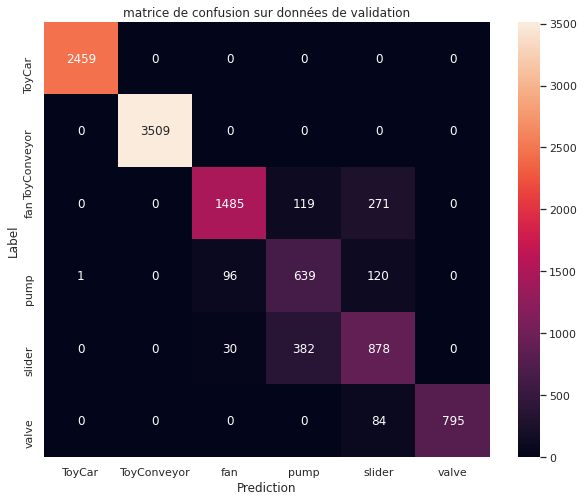

In [234]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#X_train_1, X_val, y_train_1, y_val = train_test_split(X_pca_test, label_test.numpy(), train_size=0.8,random_state=1234) #,


#knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
# knn = KNeighborsClassifier(n_neighbors=1, metric='mahalanobis', metric_params={'V':np.cov(X_train)})

#knn.fit(X_train_1, y_train_1)
print("score knn:",knn.score(X_pca_test, label_test))

y_pred = knn.predict(X_pca_test)

print(classification_report(label_test,y_pred,target_names=tb.machine_list, digits=3))

confusion_mtx = tf.math.confusion_matrix(label_test, y_pred)
plt.figure(figsize=(10, 8))
#machine_id = [machine.numpy().decode('utf-8') for machine in machineID]
#sns.heatmap(confusion_mtx, xticklabels=machine_id, yticklabels=machine_id, 
sns.heatmap(confusion_mtx, xticklabels=tb.machine_list, yticklabels=tb.machine_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('matrice de confusion sur données de validation')
plt.show()


##classification par machine, après encodage.

N'a d'intérêt que pour le modèle d'encodage par machine. 

score knn: 0.8996023856858847
                precision    recall  f1-score   support

     ToyCar_02      0.659     0.615     0.637       195
     ToyCar_03      0.500     0.473     0.486       203
     ToyCar_01      0.485     0.508     0.496       193
     ToyCar_04      0.641     0.691     0.665       191
ToyConveyor_02      0.972     0.972     0.972       211
ToyConveyor_03      0.967     0.981     0.974       207
ToyConveyor_01      0.950     0.936     0.943       203
        fan_02      0.995     0.989     0.992       189
        fan_00      0.884     0.952     0.917       168
        fan_04      0.989     0.984     0.987       189
        fan_06      1.000     1.000     1.000       181
       pump_02      1.000     0.995     0.997       186
       pump_00      0.994     1.000     0.997       165
       pump_04      1.000     1.000     1.000       129
       pump_06      0.969     0.974     0.971       190
     slider_02      0.995     0.990     0.992       197
     slider_00   

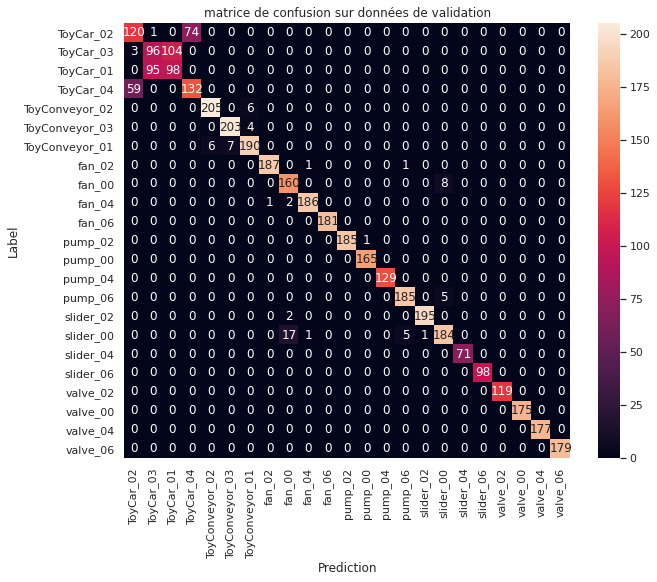

In [235]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_train_1, X_val, y_train_1, y_val = train_test_split(X_pca_train, machine_train.numpy(), train_size=0.8,random_state=1234) #,


knn_machine = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
# knn = KNeighborsClassifier(n_neighbors=1, metric='mahalanobis', metric_params={'V':np.cov(X_train)})

knn_machine.fit(X_train_1, y_train_1)
print("score knn:",knn_machine.score(X_val, y_val))

y_pred = knn_machine.predict(X_val)

print(classification_report(y_val,y_pred,target_names=tb.machine_id_list, digits=3))

confusion_mtx = tf.math.confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
#machine_id = [machine.numpy().decode('utf-8') for machine in machineID]
#sns.heatmap(confusion_mtx, xticklabels=machine_id, yticklabels=machine_id, 
sns.heatmap(confusion_mtx, xticklabels=tb.machine_id_list, yticklabels=tb.machine_id_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('matrice de confusion sur données de validation')
plt.show()



##classification par machine sur données de test: normale et anormale

score knn: 0.6745491350754509
                precision    recall  f1-score   support

     ToyCar_02      0.524     0.502     0.513       615
     ToyCar_03      0.468     0.532     0.498       615
     ToyCar_01      0.412     0.397     0.405       614
     ToyCar_04      0.421     0.397     0.408       615
ToyConveyor_02      0.966     0.968     0.967      1155
ToyConveyor_03      0.957     0.965     0.961      1154
ToyConveyor_01      0.935     0.926     0.930      1200
        fan_02      0.758     0.464     0.576       459
        fan_00      0.639     0.817     0.717       507
        fan_04      0.753     0.817     0.784       448
        fan_06      0.953     0.440     0.602       461
       pump_02      0.389     0.848     0.534       211
       pump_00      0.695     0.601     0.645       243
       pump_04      1.000     0.535     0.697       200
       pump_06      0.310     0.559     0.399       202
     slider_02      0.495     0.594     0.540       367
     slider_00   

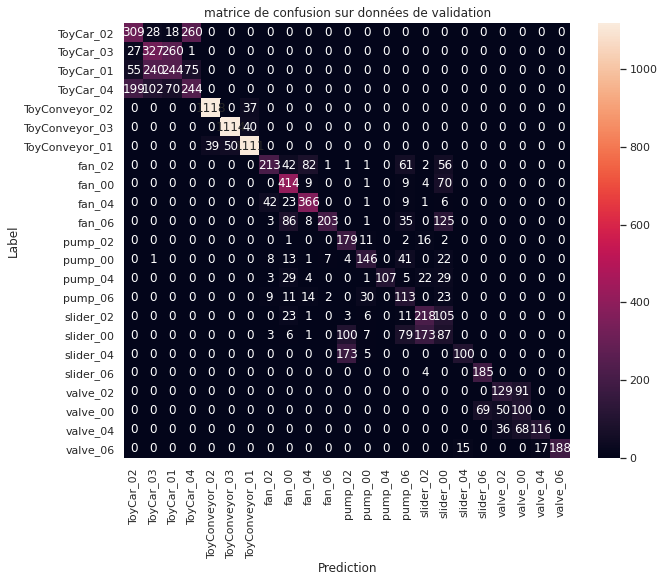

In [237]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

print("score knn:",knn_machine.score(X_pca_test, machine_test))

y_pred = knn_machine.predict(X_pca_test)

print(classification_report(machine_test,y_pred,target_names=tb.machine_id_list, digits=3))

confusion_mtx = tf.math.confusion_matrix(machine_test, y_pred)
plt.figure(figsize=(10, 8))
#machine_id = [machine.numpy().decode('utf-8') for machine in machineID]
#sns.heatmap(confusion_mtx, xticklabels=machine_id, yticklabels=machine_id, 
sns.heatmap(confusion_mtx, xticklabels=tb.machine_id_list, yticklabels=tb.machine_id_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('matrice de confusion sur données de validation')
plt.show()


# détection d'anomalies non supervisée, par machine

* Local Outlier Factor. 

En moyenne 22s par machine sont nécessaire pour optimiser l'algorithme sur la machine testée et rendre ses performances de test.

Pour l'ensemble du dataset, il faut compter moins de 11 mn.  

In [238]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import time
import matplotlib.font_manager
from sklearn.metrics import roc_curve, auc


## Tests sur encodage par type de machine

In [224]:
neighbors= [10,20,30,40,60,80,90,100,110,120,130,150,200,250,300]
contamination= np.linspace(0.5,1e-5,25)

component=3
pca = PCA(component) #
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

specificite,sensibilite,history_test_valve,result = run_test_LOF(X_pca_train,X_pca_test,machine_train,machine_test,anomaly_test,contamination=contamination,params_algo=neighbors, pca_reduction=False, components=component, seuil1=70,seuil2=90,verbose=1)


In [226]:
idx,score=analyse_test(specificite,sensibilite)

idx_conta = 21

result_fin = pd.DataFrame(columns=['type','machine','sensibilite','specificite','composantes','contamination','modele_encodage'])

print("|       machine       |  voisins  | score  |  sensibilité  |  specificite  |")
for m,mach in enumerate(tb.machine_id_list):
  resultfilter = result[(result.machine==mach) & (result.neighbors==neighbors[idx[m]]) & (result.idx_outlier==idx_conta) & (result.component==component)]
  print("|{:20s} | {:9d} |{:7.2f} | {:13.3f} | {:13.2f} |".format(mach,neighbors[idx[m]],score[m],resultfilter.sensibilite.values[0],resultfilter.specificite.values[0]))
  result_fin=result_fin.append({'type':resultfilter['type'].values[0],
                                'machine':mach,
                                'sensibilite':resultfilter.sensibilite.values[0],
                                'specificite':resultfilter.specificite.values[0],
                                'composantes': component,
                                'contamination':contamination[idx_conta],
                                'modele_encodage': 'all_weight_encoder_model_machine'},
                               ignore_index=True)
  

|       machine       |  voisins  | score  |  sensibilité  |  specificite  |
|ToyCar_02            |        40 |   0.22 |         0.170 |          0.90 |
|ToyCar_03            |        10 |   0.20 |         0.136 |          0.89 |
|ToyCar_01            |        20 |   0.21 |         0.129 |          0.91 |
|ToyCar_04            |       150 |   0.20 |         0.136 |          0.91 |
|ToyConveyor_02       |       110 |   0.19 |         0.096 |          0.90 |
|ToyConveyor_03       |       110 |   0.23 |         0.161 |          0.90 |
|ToyConveyor_01       |       110 |   0.21 |         0.135 |          0.92 |
|fan_02               |        80 |   0.36 |         0.574 |          0.83 |
|fan_00               |        80 |   0.35 |         0.437 |          0.73 |
|fan_04               |        80 |   0.41 |         0.549 |          0.80 |
|fan_06               |       110 |   0.58 |         0.776 |          0.84 |
|pump_02              |       130 |   0.34 |         0.369 |          0.82 |

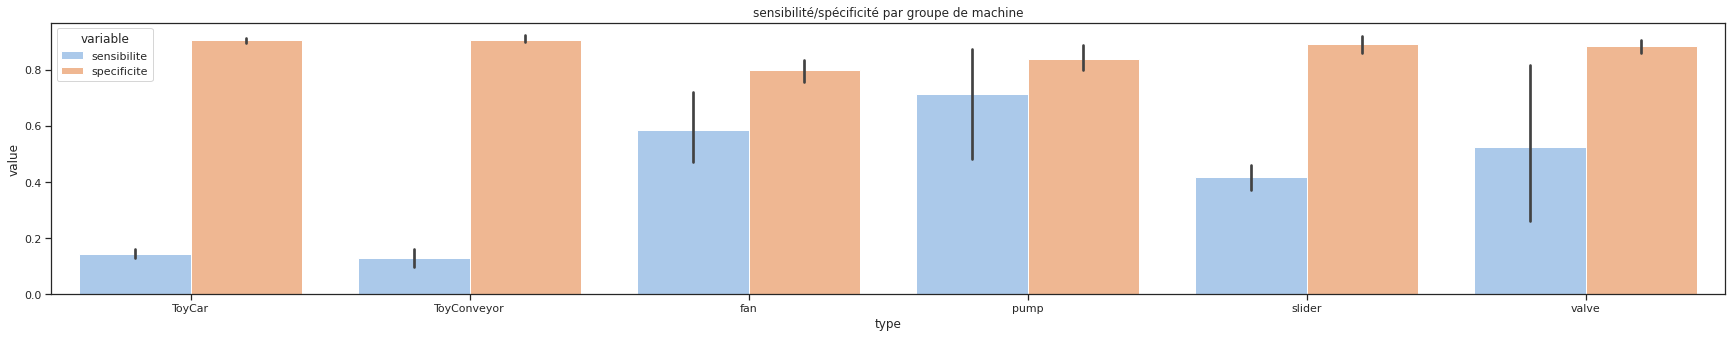

In [227]:
import plotly.graph_objects as go

x = [[],[]]
for t in result_fin['type'].unique():
  sous_cat = result_fin[result_fin['type']==t].machine.unique()
  x[0].extend([t for i in range(len(sous_cat))])
  x[1].extend(sous_cat)

fig = go.Figure(go.Bar(x=x, y=result_fin.sensibilite, name='sensibilité'))
fig.add_trace(go.Bar(x=x, y=result_fin.specificite, name='spécificité'))

fig.update_layout(title='performance: cumul sensibilité/spécificité') #barmode='stack'
fig.update_xaxes(categoryorder='category ascending')
fig.update_yaxes(range=[0,1.05])
fig.show()

fig2 = go.Figure(go.Bar(x=result_fin.machine, y=result_fin.sensibilite, name='sensibilité'))
fig2.add_trace(go.Bar(x=result_fin.machine, y=result_fin.specificite, name='spécificité'))

fig2.update_layout(title='classement des performances par machine') #barmode='stack',
fig2.update_xaxes(categoryorder='total descending')
fig2.update_yaxes(range=[0,1.05])
fig2.show()

display_result=pd.melt(result_fin,id_vars=['type','machine'],value_vars=['sensibilite', 'specificite'])
plt.figure(figsize=(30,5))
sns.set_theme(style="ticks", palette="pastel")
sns.barplot(data=display_result,x='type',y='value', hue='variable');
plt.title('sensibilité/spécificité par groupe de machine')
plt.show()

In [ ]:
# plt.figure(figsize=(30,5))
# sns.boxplot(x="type", y="value",
#             hue="variable",
#             data=display_result)

## test avec encodage par id machine

encodage par machine: veuillez à bien charger le bon encodeur et encoder les données avant de lancer les prochaines cellules



In [239]:
neighbors= [10,20,30,40,60,80,90,100,110,120,130,150,200,250,300]
contamination= np.linspace(0.5,1e-5,25)

component=3
pca = PCA(component) #
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

specificite,sensibilite,history_test_valve,result = run_test_LOF(X_pca_train,X_pca_test,machine_train,machine_test,anomaly_test,contamination=contamination,params_algo=neighbors, pca_reduction=False, components=component, seuil1=70,seuil2=90,verbose=1)


In [242]:
idx,score=analyse_test(specificite,sensibilite)

idx_conta = 21

result_fin = pd.DataFrame(columns=['type','machine','sensibilite','specificite','composantes','contamination','modele_encodage'])

print("|       machine       |  voisins  | score  |  sensibilité  |  specificite  |")
for m,mach in enumerate(tb.machine_id_list):
  resultfilter = result[(result.machine==mach) & (result.neighbors==neighbors[idx[m]]) & (result.idx_outlier==idx_conta) & (result.component==component)]
  print("|{:20s} | {:9d} |{:7.2f} | {:13.3f} | {:13.2f} |".format(mach,neighbors[idx[m]],score[m],resultfilter.sensibilite.values[0],resultfilter.specificite.values[0]))
  result_fin=result_fin.append({'type':resultfilter['type'].values[0],
                                'machine':mach,
                                'sensibilite':resultfilter.sensibilite.values[0],
                                'specificite':resultfilter.specificite.values[0],
                                'composantes': component,
                                'contamination':contamination[idx_conta],
                                'modele_encodage': 'all_weight_encoder_model_machine'},
                               ignore_index=True)

|       machine       |  voisins  | score  |  sensibilité  |  specificite  |
|ToyCar_02            |        10 |   0.49 |         0.758 |          0.93 |
|ToyCar_03            |        10 |   0.30 |         0.283 |          0.89 |
|ToyCar_01            |       300 |   0.44 |         0.580 |          0.90 |
|ToyCar_04            |        20 |   0.50 |         0.743 |          0.93 |
|ToyConveyor_02       |        10 |   0.19 |         0.107 |          0.92 |
|ToyConveyor_03       |        30 |   0.22 |         0.130 |          0.94 |
|ToyConveyor_01       |        10 |   0.26 |         0.182 |          0.92 |
|fan_02               |       150 |   0.59 |         0.830 |          0.90 |
|fan_00               |        20 |   0.26 |         0.125 |          0.87 |
|fan_04               |       250 |   0.33 |         0.414 |          0.86 |
|fan_06               |        60 |   0.52 |         0.773 |          0.91 |
|pump_02              |       300 |   0.48 |         0.595 |          0.68 |

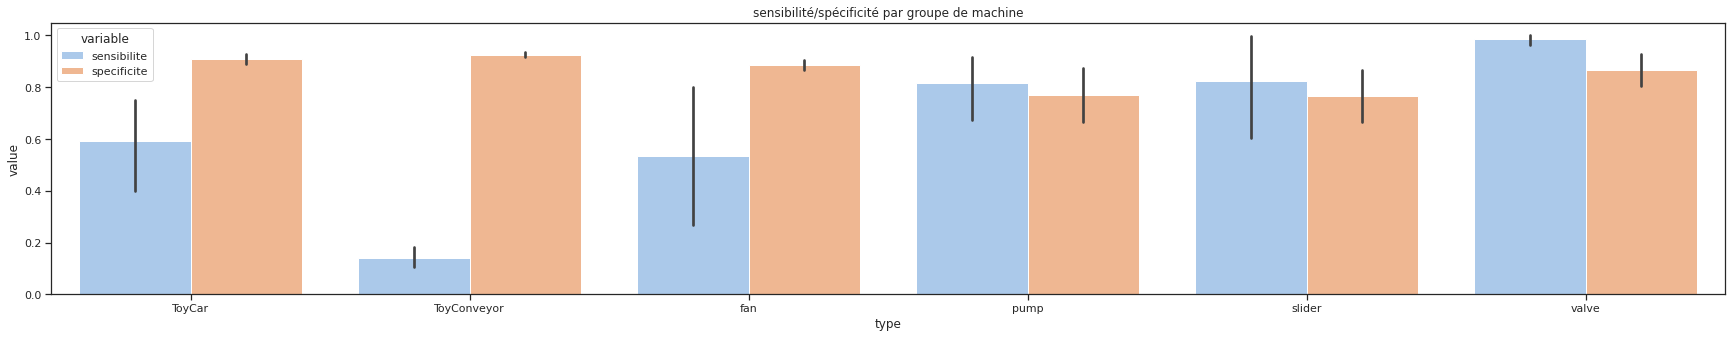

In [243]:
import plotly.graph_objects as go

x = [[],[]]
for t in result_fin['type'].unique():
  sous_cat = result_fin[result_fin['type']==t].machine.unique()
  x[0].extend([t for i in range(len(sous_cat))])
  x[1].extend(sous_cat)

fig = go.Figure(go.Bar(x=x, y=result_fin.sensibilite, name='sensibilité'))
fig.add_trace(go.Bar(x=x, y=result_fin.specificite, name='spécificité'))

fig.update_layout(title='performance: cumul sensibilité/spécificité') #barmode='stack'
fig.update_xaxes(categoryorder='category ascending')
fig.update_yaxes(range=[0,1.05])
fig.show()

fig2 = go.Figure(go.Bar(x=result_fin.machine, y=result_fin.sensibilite, name='sensibilité'))
fig2.add_trace(go.Bar(x=result_fin.machine, y=result_fin.specificite, name='spécificité'))

fig2.update_layout(title='classement des performances par machine') #barmode='stack',
fig2.update_xaxes(categoryorder='total descending')
fig2.update_yaxes(range=[0,1.05])
fig2.show()

display_result=pd.melt(result_fin,id_vars=['type','machine'],value_vars=['sensibilite', 'specificite'])
plt.figure(figsize=(30,5))
sns.set_theme(style="ticks", palette="pastel")
sns.barplot(data=display_result,x='type',y='value', hue='variable');
plt.title('sensibilité/spécificité par groupe de machine')
plt.show()